In [1]:
import os
import cv2
import numpy as np
import sys

from scipy.optimize import minimize
import math


import ds_layer #Dempster-Shafer layer
import utility_layer_train #Utility layer for training
import utility_layer_test #Utility layer for training
import AU_imprecision


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint

In [2]:
train_images = np.load('/Python/HAM1000/HAM10000_npy/train_image.npy')
train_labels = np.load('/Python/HAM1000/HAM10000_npy/train_label.npy')

test_images = np.load('/Python/HAM1000/HAM10000_npy/test_image.npy')
test_labels = np.load('/Python/HAM1000/HAM10000_npy/test_label.npy')


In [3]:
# train_images, test_images, train_labels, test_labels = train_test_split(
#     x_images, y_labels, test_size=0.1, random_state=42)

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# del x_images
# del y_labels

Train images shape: (6409, 32, 32, 3)
Train labels shape: (6409, 1)
Test images shape: (2003, 32, 32, 3)
Test labels shape: (2003, 1)


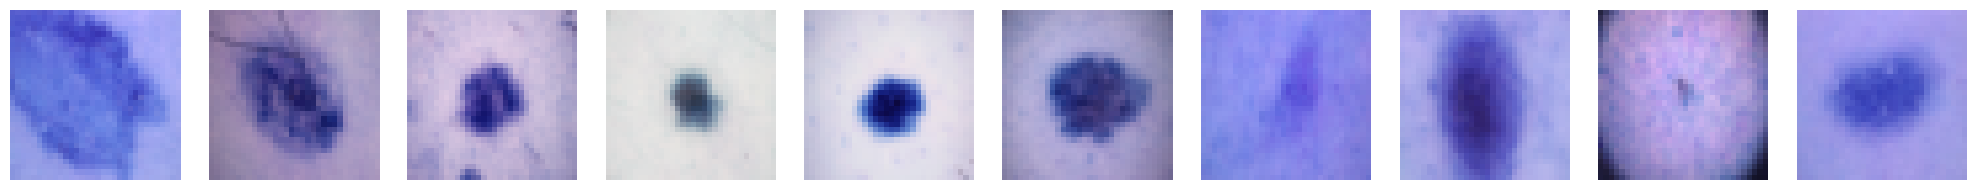

In [4]:
np.random.seed(42)

random_indices = np.random.choice(train_images.shape[0], size=10, replace=False)
fig = plt.figure(figsize=(20, 2))
for i, index in enumerate(random_indices):
    ax = fig.add_subplot(1, 10, i+1)
    train_images[index] = cv2.cvtColor(train_images[index], cv2.COLOR_BGR2RGB)
    ax.imshow(train_images[index].astype("uint8"))
    ax.axis('off')

fig.tight_layout()
plt.show()

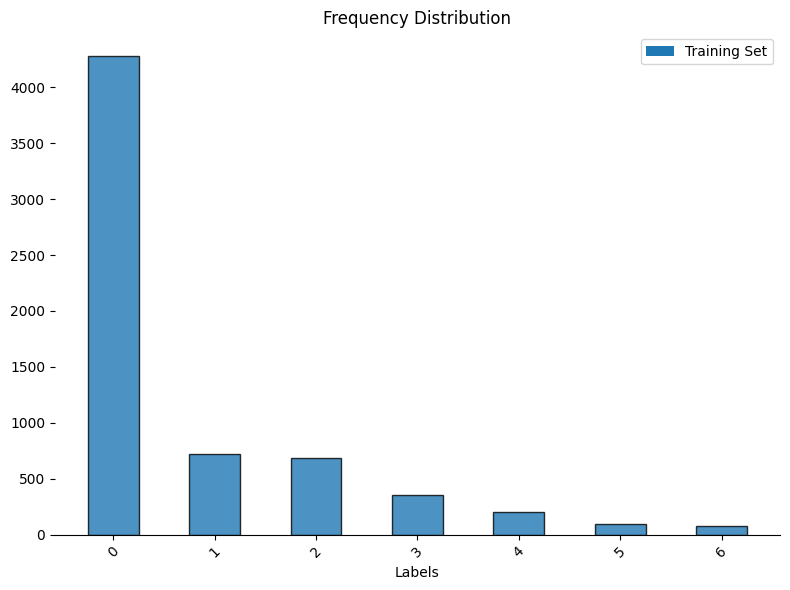

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load the numpy files
labels = train_labels
unique_labels, label_counts = np.unique(labels, return_counts=True)
fig, ax = plt.subplots(figsize=(8, 6))

bar_color = '#1f77b4' # Red color for the bars
bar_width = 0.5  # Width of the bars
bar_alpha = 0.8  # Transparency of the bars
bar_edgecolor = 'black'  # Edge color of the bars


bar_plot = ax.bar(unique_labels, label_counts, width=bar_width, color=bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
ax.set_xlabel('Labels')
ax.set_title('Frequency Distribution')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
custom_legend = [plt.Rectangle((0, 0), 1, 1, fc=bar_color)]
legend_labels = ['Training Set']
ax.legend(custom_legend, legend_labels)
fig.tight_layout()
plt.show()

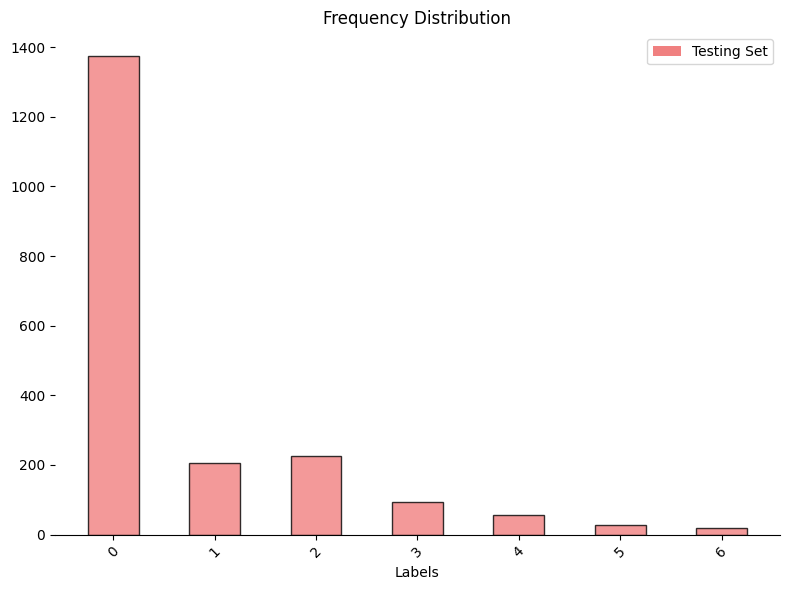

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load the numpy files
labels = test_labels

unique_labels, label_counts = np.unique(labels, return_counts=True)
fig, ax = plt.subplots(figsize=(8, 6))

bar_color = 'lightcoral' # Red color for the bars
bar_width = 0.5  # Width of the bars
bar_alpha = 0.8  # Transparency of the bars
bar_edgecolor = 'black'  # Edge color of the bars


bar_plot = ax.bar(unique_labels, label_counts, width=bar_width, color=bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
ax.set_xlabel('Labels')
ax.set_title('Frequency Distribution')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
custom_legend = [plt.Rectangle((0, 0), 1, 1, fc=bar_color)]
legend_labels = ['Testing Set']
ax.legend(custom_legend, legend_labels)
fig.tight_layout()
plt.show()

## Probabilitstic Fitnet-4 classifier

In [7]:
from tensorflow import keras
num_classes = 7
train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes)
test_labels_one_hot = keras.utils.to_categorical(test_labels, num_classes)

In [8]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = train_images.shape[1:]

In [9]:
import tensorflow as tf

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
#     start_from_epoch=8
)

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(verbose=1,min_lr=0.00000001, patience=5,),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
]

In [10]:
num_class=num_classes

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
bt1 = tf.keras.layers.BatchNormalization()(c1_5)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
dr1 = tf.keras.layers.Dropout(0.5)(p1)


c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
bt2 = tf.keras.layers.BatchNormalization()(c2_5)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
dr2 = tf.keras.layers.Dropout(0.5)(p2)

c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
bt3 = tf.keras.layers.BatchNormalization()(c3_5)
p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
dr3 = tf.keras.layers.Dropout(0.5)(p3)

flatten1=tf.keras.layers.Flatten()(dr3)

outputs = tf.keras.layers.Dense(num_class, activation='softmax')(flatten1)

model_p = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_p.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), #lr=0.005
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_p.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 48)        13872     
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 48)        20784     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 48)       192   

H:\Python\Anaconda\envs\tensorflow-gpu\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
filepath = '/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_fina'#please define our own filepath to save the weights of the probabilistic FitNet-4 classifier
checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=True, save_weights_only=True,
    save_frequency=1)

model_p.fit(train_images, train_labels_one_hot, batch_size=25, epochs=200, verbose=1, callbacks=[checkpoint_callback], validation_data=(test_images, test_labels_one_hot), shuffle=True)

Epoch 1/200
257/257 [==============================] - ETA: 0s - loss: 1.6379 - accuracy: 0.5912
Epoch 1: val_accuracy improved from -inf to 0.68597, saving model to /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32\cnn_checkpoint_fina
257/257 [==============================] - 8s 18ms/step - loss: 1.6379 - accuracy: 0.5912 - val_loss: 2.3431 - val_accuracy: 0.6860
Epoch 2/200
256/257 [============================>.] - ETA: 0s - loss: 1.0648 - accuracy: 0.6502
Epoch 2: val_accuracy did not improve from 0.68597
257/257 [==============================] - 4s 16ms/step - loss: 1.0642 - accuracy: 0.6503 - val_loss: 1.2464 - val_accuracy: 0.4698
Epoch 3/200
255/257 [============================>.] - ETA: 0s - loss: 0.9610 - accuracy: 0.6703
Epoch 3: val_accuracy did not improve from 0.68597
257/257 [==============================] - 4s 16ms/step - loss: 0.9618 - accuracy: 0.6700 - val_loss: 1.1839 - val_accuracy: 0.6640
Epoch 4/200
257/257 [==============================] - ETA

256/257 [============================>.] - ETA: 0s - loss: 0.7477 - accuracy: 0.7323
Epoch 28: val_accuracy did not improve from 0.74938
257/257 [==============================] - 4s 16ms/step - loss: 0.7472 - accuracy: 0.7323 - val_loss: 1.4948 - val_accuracy: 0.6870
Epoch 29/200
255/257 [============================>.] - ETA: 0s - loss: 0.7382 - accuracy: 0.7280
Epoch 29: val_accuracy did not improve from 0.74938
257/257 [==============================] - 4s 17ms/step - loss: 0.7388 - accuracy: 0.7279 - val_loss: 0.8391 - val_accuracy: 0.7424
Epoch 30/200
255/257 [============================>.] - ETA: 0s - loss: 0.7102 - accuracy: 0.7407
Epoch 30: val_accuracy improved from 0.74938 to 0.75287, saving model to /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32\cnn_checkpoint_fina
257/257 [==============================] - 4s 16ms/step - loss: 0.7115 - accuracy: 0.7405 - val_loss: 0.7091 - val_accuracy: 0.7529
Epoch 31/200
255/257 [============================>.] - ETA: 0

257/257 [==============================] - 5s 18ms/step - loss: 0.7004 - accuracy: 0.7454 - val_loss: 0.7229 - val_accuracy: 0.7244
Epoch 57/200
256/257 [============================>.] - ETA: 0s - loss: 0.6682 - accuracy: 0.7580
Epoch 57: val_accuracy did not improve from 0.77084
257/257 [==============================] - 4s 16ms/step - loss: 0.6678 - accuracy: 0.7582 - val_loss: 0.7819 - val_accuracy: 0.7174
Epoch 58/200
255/257 [============================>.] - ETA: 0s - loss: 0.6410 - accuracy: 0.7595
Epoch 58: val_accuracy did not improve from 0.77084
257/257 [==============================] - 4s 17ms/step - loss: 0.6407 - accuracy: 0.7597 - val_loss: 0.6513 - val_accuracy: 0.7544
Epoch 59/200
256/257 [============================>.] - ETA: 0s - loss: 0.6220 - accuracy: 0.7669
Epoch 59: val_accuracy did not improve from 0.77084
257/257 [==============================] - 4s 17ms/step - loss: 0.6220 - accuracy: 0.7667 - val_loss: 0.6739 - val_accuracy: 0.7539
Epoch 60/200
255/257 [

254/257 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.8901
Epoch 85: val_accuracy did not improve from 0.77683
257/257 [==============================] - 4s 17ms/step - loss: 0.2874 - accuracy: 0.8891 - val_loss: 0.8494 - val_accuracy: 0.7419
Epoch 86/200
256/257 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8955
Epoch 86: val_accuracy did not improve from 0.77683
257/257 [==============================] - 5s 18ms/step - loss: 0.2885 - accuracy: 0.8953 - val_loss: 0.8142 - val_accuracy: 0.7494
Epoch 87/200
254/257 [============================>.] - ETA: 0s - loss: 0.2797 - accuracy: 0.8959
Epoch 87: val_accuracy did not improve from 0.77683
257/257 [==============================] - 5s 18ms/step - loss: 0.2796 - accuracy: 0.8961 - val_loss: 0.9220 - val_accuracy: 0.7564
Epoch 88/200
254/257 [============================>.] - ETA: 0s - loss: 0.2808 - accuracy: 0.8989
Epoch 88: val_accuracy did not improve from 0.77683
257/257 [========

Epoch 114/200
257/257 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9558
Epoch 114: val_accuracy did not improve from 0.77683
257/257 [==============================] - 4s 16ms/step - loss: 0.1334 - accuracy: 0.9558 - val_loss: 1.3093 - val_accuracy: 0.7419
Epoch 115/200
256/257 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9542
Epoch 115: val_accuracy did not improve from 0.77683
257/257 [==============================] - 4s 15ms/step - loss: 0.1333 - accuracy: 0.9541 - val_loss: 1.3048 - val_accuracy: 0.7404
Epoch 116/200
257/257 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9552
Epoch 116: val_accuracy did not improve from 0.77683
257/257 [==============================] - 4s 16ms/step - loss: 0.1309 - accuracy: 0.9552 - val_loss: 1.1591 - val_accuracy: 0.7299
Epoch 117/200
257/257 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9543
Epoch 117: val_accuracy did not improve from 0.77

Epoch 143/200
255/257 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9733
Epoch 143: val_accuracy did not improve from 0.77683
257/257 [==============================] - 4s 16ms/step - loss: 0.0796 - accuracy: 0.9733 - val_loss: 1.5336 - val_accuracy: 0.7134
Epoch 144/200
255/257 [============================>.] - ETA: 0s - loss: 0.0825 - accuracy: 0.9727
Epoch 144: val_accuracy did not improve from 0.77683
257/257 [==============================] - 4s 16ms/step - loss: 0.0821 - accuracy: 0.9729 - val_loss: 1.3611 - val_accuracy: 0.7509
Epoch 145/200
254/257 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9729
Epoch 145: val_accuracy did not improve from 0.77683
257/257 [==============================] - 4s 17ms/step - loss: 0.0889 - accuracy: 0.9730 - val_loss: 1.5264 - val_accuracy: 0.7224
Epoch 146/200
257/257 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9749
Epoch 146: val_accuracy did not improve from 0.77

Epoch 172/200
257/257 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9800
Epoch 172: val_accuracy did not improve from 0.77683
257/257 [==============================] - 4s 16ms/step - loss: 0.0601 - accuracy: 0.9800 - val_loss: 1.4790 - val_accuracy: 0.7324
Epoch 173/200
254/257 [============================>.] - ETA: 0s - loss: 0.0719 - accuracy: 0.9783
Epoch 173: val_accuracy did not improve from 0.77683
257/257 [==============================] - 4s 16ms/step - loss: 0.0726 - accuracy: 0.9782 - val_loss: 1.6122 - val_accuracy: 0.7399
Epoch 174/200
256/257 [============================>.] - ETA: 0s - loss: 0.0571 - accuracy: 0.9812
Epoch 174: val_accuracy did not improve from 0.77683
257/257 [==============================] - 4s 16ms/step - loss: 0.0574 - accuracy: 0.9811 - val_loss: 1.5782 - val_accuracy: 0.7374
Epoch 175/200
253/257 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9777
Epoch 175: val_accuracy did not improve from 0.77

In [12]:
model_p.load_weights('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_fina')
model_p.evaluate(train_images, train_labels_one_hot, batch_size=25, verbose=1)
model_p.evaluate(test_images, test_labels_one_hot, batch_size=25, verbose=1)

81/81 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.7768


[0.6851345300674438, 0.7768347263336182]

In [13]:
# Save model in HDF5 format (.h5)
model_p.save(filepath + 'model.h5')
tf.saved_model.save(model_p, filepath + 'saved_model/')


INFO:tensorflow:Assets written to: /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_finasaved_model/assets


INFO:tensorflow:Assets written to: /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_finasaved_model/assets


## Evidential - FitNet4

In [15]:
print(IMG_WIDTH)
print(IMG_HEIGHT)
print(num_class)
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
print(inputs_pixels)

32
32
7
1024


In [16]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes = 200
prototypes=200

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
bt1 = tf.keras.layers.BatchNormalization()(c1_5)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
dr1 = tf.keras.layers.Dropout(0.5)(p1)


c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
bt2 = tf.keras.layers.BatchNormalization()(c2_5)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
dr2 = tf.keras.layers.Dropout(0.5)(p2)

c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
bt3 = tf.keras.layers.BatchNormalization()(c3_5)
p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
dr3 = tf.keras.layers.Dropout(0.5)(p3)
flatten1=tf.keras.layers.Flatten()(dr3)

ED = ds_layer.DS1(prototypes,128)(flatten1)
ED_ac = ds_layer.DS1_activate(prototypes)(ED)
mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

outputs = utility_layer_train.DM(0.9, num_class)(mass_Dempster_normalize)


model_e = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_e.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_e.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 48)        13872     
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 48)        20784     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 48)       192 

H:\Python\Anaconda\envs\tensorflow-gpu\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
model_e.load_weights('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_fina')
feature = tf.keras.Model(inputs=[inputs], outputs=[flatten1])
x_train_feature = feature.predict(train_images)
x_test_feature = feature.predict(test_images)

inputs = tf.keras.layers.Input(128)
ED = ds_layer.DS1(prototypes,128)(inputs)
ED_ac = ds_layer.DS1_activate(prototypes)(ED)
mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)
outputs = utility_layer_train.DM(0.9, num_class)(mass_Dempster_normalize)
model_mid = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_mid.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), #0.001
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_mid.fit(x_train_feature, train_labels_one_hot, batch_size=25,  epochs=2, verbose=1, validation_data=(x_test_feature, test_labels_one_hot), shuffle=True)


model_e.load_weights('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_fina')
DSLAYER_DS1_W = tf.reshape(model_mid.layers[1].get_weights()[0], [1, 200, 128])
DSLAYER_DS1_activate_W = model_mid.layers[2].get_weights()
DSLAYER_DS2_W = model_mid.layers[3].get_weights()
model_e.layers[26].set_weights(DSLAYER_DS1_W)
model_e.layers[27].set_weights(DSLAYER_DS1_activate_W)
model_e.layers[28].set_weights(DSLAYER_DS2_W)


filepath = '/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/evidential_DL_200_checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=True, save_weights_only=True,
    save_frequency=1)
model_e.fit(train_images, train_labels_one_hot, batch_size=25,  epochs=3, verbose=1, callbacks=[checkpoint_callback], validation_data=(test_images, test_labels_one_hot), shuffle=True)

63/63 [==============================] - 0s 4ms/step
Epoch 1/2
257/257 [==============================] - 86s 172ms/step - loss: 0.9438 - accuracy: 0.6600 - val_loss: 0.9180 - val_accuracy: 0.6520
Epoch 2/2
257/257 [==============================] - 40s 155ms/step - loss: 0.7427 - accuracy: 0.7461 - val_loss: 0.8475 - val_accuracy: 0.7209
Epoch 1/3
257/257 [==============================] - ETA: 0s - loss: 0.8367 - accuracy: 0.7265
Epoch 1: val_accuracy improved from -inf to 0.71842, saving model to /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32\evidential_DL_200_checkpoint
257/257 [==============================] - 94s 188ms/step - loss: 0.8367 - accuracy: 0.7265 - val_loss: 0.9141 - val_accuracy: 0.7184
Epoch 2/3
257/257 [==============================] - ETA: 0s - loss: 0.7672 - accuracy: 0.7391
Epoch 2: val_accuracy did not improve from 0.71842
257/257 [==============================] - 44s 170ms/step - loss: 0.7672 - accuracy: 0.7391 - val_loss: 0.9994 - val_accur

In [18]:
model_e.load_weights('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/evidential_DL_200_checkpoint')
model_e.evaluate(train_images, train_labels_one_hot, batch_size=25, verbose=1)
model_e.evaluate(test_images, test_labels_one_hot, batch_size=25, verbose=1)

81/81 [==============================] - 3s 33ms/step - loss: 0.9141 - accuracy: 0.7184


[0.9140844345092773, 0.7184223532676697]

In [19]:
num_class=num_classes
def func(x):
  fun=0
  for i in range(len(x)):
    fun += x[i] * math.log10(x[i])
  return fun

def cons1(x):
  return sum(x)

def cons2(x):
  tol = 0
  for i in range(len(x)):
    tol += (len(x) -(i+1)) * x[i] / (len(x) - 1)
  return tol

In [20]:
for j in range(2,(num_class+1)):
  num_weights = j
  ini_weights = np.asarray(np.random.rand(num_weights))

  name='weight'+str(j)
  locals()['weight'+str(j)]= np.zeros([5, j])

  for i in range(5):
    tol = 0.5 + i * 0.1

    cons = ({'type': 'eq', 'fun' : lambda x: cons1(x)-1},
          {'type': 'eq', 'fun' : lambda x: cons2(x)-tol},
          {'type': 'ineq', 'fun' : lambda x: x-0.00000001}
        )
  
    res = minimize(func, ini_weights, method='SLSQP', options={'disp': True}, constraints=cons)
    locals()['weight'+str(j)][i] = res.x
    print (res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.30102999566398114
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.5 0.5]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.29228525323862886
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.6 0.4]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2652949955741215
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.7 0.3]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.21732201127364892
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.8 0.2]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.14118174150460777
            It

In [21]:
def PowerSetsBinary(items):  
    N = len(items)   
    set_all=[]
    for i in range(2**N):
        combo = []  
        for j in range(N):  
            if(i >> j ) % 2 == 1:  
                combo.append(items[j]) 
        set_all.append(combo)
    return set_all

In [22]:
class_set=list(range(num_class))
act_set= PowerSetsBinary(class_set)
act_set.remove(act_set[0])#emptyset is not needed
act_set=sorted(act_set)
print(act_set)
print(len(act_set))

[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 6], [0, 1, 2, 3, 5], [0, 1, 2, 3, 5, 6], [0, 1, 2, 3, 6], [0, 1, 2, 4], [0, 1, 2, 4, 5], [0, 1, 2, 4, 5, 6], [0, 1, 2, 4, 6], [0, 1, 2, 5], [0, 1, 2, 5, 6], [0, 1, 2, 6], [0, 1, 3], [0, 1, 3, 4], [0, 1, 3, 4, 5], [0, 1, 3, 4, 5, 6], [0, 1, 3, 4, 6], [0, 1, 3, 5], [0, 1, 3, 5, 6], [0, 1, 3, 6], [0, 1, 4], [0, 1, 4, 5], [0, 1, 4, 5, 6], [0, 1, 4, 6], [0, 1, 5], [0, 1, 5, 6], [0, 1, 6], [0, 2], [0, 2, 3], [0, 2, 3, 4], [0, 2, 3, 4, 5], [0, 2, 3, 4, 5, 6], [0, 2, 3, 4, 6], [0, 2, 3, 5], [0, 2, 3, 5, 6], [0, 2, 3, 6], [0, 2, 4], [0, 2, 4, 5], [0, 2, 4, 5, 6], [0, 2, 4, 6], [0, 2, 5], [0, 2, 5, 6], [0, 2, 6], [0, 3], [0, 3, 4], [0, 3, 4, 5], [0, 3, 4, 5, 6], [0, 3, 4, 6], [0, 3, 5], [0, 3, 5, 6], [0, 3, 6], [0, 4], [0, 4, 5], [0, 4, 5, 6], [0, 4, 6], [0, 5], [0, 5, 6], [0, 6], [1], [1, 2], [1, 2, 3], [1, 2, 3, 4], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 6], [1, 2, 3, 5

In [23]:
utility_matrix = np.zeros([len(act_set), len(class_set)])
tol_i = 3 
for i in range(len(act_set)):
  intersec = class_set and act_set[i]
  if len(intersec) == 1:
    utility_matrix[i, intersec] = 1
  
  else:
    for j in range(len(intersec)):
      utility_matrix[i, intersec[j]] = locals()['weight'+str(len(intersec))][tol_i, 0]
print (utility_matrix)

[[1.         0.         0.         0.         0.         0.
  0.        ]
 [0.8        0.8        0.         0.         0.         0.
  0.        ]
 [0.68188629 0.68188629 0.68188629 0.         0.         0.
  0.        ]
 [0.59646995 0.59646995 0.59646995 0.59646995 0.         0.
  0.        ]
 [0.53067919 0.53067919 0.53067919 0.53067919 0.53067919 0.
  0.        ]
 [0.4781138  0.4781138  0.4781138  0.4781138  0.4781138  0.4781138
  0.        ]
 [0.43535828 0.43535828 0.43535828 0.43535828 0.43535828 0.43535828
  0.43535828]
 [0.4781138  0.4781138  0.4781138  0.4781138  0.4781138  0.
  0.4781138 ]
 [0.53067919 0.53067919 0.53067919 0.53067919 0.         0.53067919
  0.        ]
 [0.4781138  0.4781138  0.4781138  0.4781138  0.         0.4781138
  0.4781138 ]
 [0.53067919 0.53067919 0.53067919 0.53067919 0.         0.
  0.53067919]
 [0.59646995 0.59646995 0.59646995 0.         0.59646995 0.
  0.        ]
 [0.53067919 0.53067919 0.53067919 0.         0.53067919 0.53067919
  0.        ]


In [24]:

prototypes=200
number_act_set = len(act_set)

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))


c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
bt1 = tf.keras.layers.BatchNormalization()(c1_5)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
dr1 = tf.keras.layers.Dropout(0.5)(p1)


c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
bt2 = tf.keras.layers.BatchNormalization()(c2_5)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
dr2 = tf.keras.layers.Dropout(0.5)(p2)

c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
bt3 = tf.keras.layers.BatchNormalization()(c3_5)
p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
dr3 = tf.keras.layers.Dropout(0.5)(p3)
flatten1=tf.keras.layers.Flatten()(dr3)

#DS layer
ED = ds_layer.DS1(prototypes,128)(flatten1)
ED_ac = ds_layer.DS1_activate(prototypes)(ED)
mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

#Utility layer for testing
outputs = utility_layer_test.DM_test(num_class, number_act_set, 0.9)(mass_Dempster_normalize)


model_e_imprecise = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_e_imprecise.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_e_imprecise.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 48)        13872     
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 48)        20784     
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 48)       192 

In [30]:
model_e_imprecise.layers[-1].set_weights(tf.reshape(utility_matrix, [1, 127, 7]))
model_e_imprecise.load_weights('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/evidential_DL_200_checkpoint')

In [34]:
resutls = tf.argmax(model_e_imprecise.predict(test_images),-1)
imprecise_results =[]
for i in range(len(resutls)):
  act_local = resutls[i]
  set_valued_results = act_set[act_local]
  imprecise_results.append(set_valued_results)
print (imprecise_results)
average_utility_imprecision = AU_imprecision.average_utility(utility_matrix, resutls, test_labels, act_set)
print (average_utility_imprecision)

63/63 [==============================] - 3s 48ms/step
[[0], [3, 4], [2], [0], [0], [0], [0], [2], [0], [0], [0], [0, 1, 2], [1], [0, 1, 2], [0], [0], [0], [0], [0, 3], [0], [0, 2], [0, 1, 2, 3], [1, 2], [0, 2, 3], [0, 1, 2, 3], [0, 1, 2], [0, 3], [2], [0, 1, 3, 4], [0, 1, 2], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1, 2], [0], [0], [0], [0], [2], [0, 3], [0], [0], [0], [0], [0, 1, 2], [0], [0], [0], [0], [3, 4], [0], [0, 1, 3], [0, 3, 4], [0], [0, 2, 3], [0], [0, 2], [1, 2], [0], [3, 4], [0, 1, 2, 3, 4], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 1], [0], [0, 1], [3, 4], [0, 2], [0], [0], [0], [2], [0], [0], [0], [3, 4], [0, 1, 2], [0], [3, 4], [0], [0], [0], [0], [0, 2, 3, 4], [0], [0], [0], [2], [0], [0], [0], [0, 1, 2], [0, 1, 2], [0], [0, 3, 4], [0], [0, 2], [0], [0, 2], [0], [0], [0], [0], [0, 2, 3, 4], [0], [0], [0], [0], [0], [0], [0], [0, 1, 2], [0], [0, 2], [0], [0], [3, 4], [0], [0], [0, 1], [0], [0, 1], [0], [2, 3, 4], [2], [0], [0], [3, 4], [0, 1], [0], [0,

[0.75908831]
